# Import Dependencies

In [59]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset

In [60]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Define the path to your training data
train_data_path = '/content/drive/MyDrive/archive (2)/training/training'
test_data_path = '/content/drive/MyDrive/archive (2)/validation/validation'

# Check if the directory exists
if not os.path.isdir(train_data_path):
    print("The directory does not exist.")
else:
    print("The directory exists.")

# Define the transform
train_trans = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load the dataset
try:
    train_dataset = datasets.ImageFolder(root=train_data_path, transform=train_trans)
    print("Dataset loaded successfully.")
except FileNotFoundError as e:
    print("FileNotFoundError:", e)
except Exception as e:
    print("An error occurred:", e)


The directory exists.
Dataset loaded successfully.


# Training and Testing dataset



In [61]:
# Define the path to your training data
train_data_path = '/content/drive/MyDrive/archive (2)/training/training'
test_data_path = '/content/drive/MyDrive/archive (2)/validation/validation'

In [62]:
mean=[0.4363, 0.4328, 0.3291]
std=[0.2129, 0.2075, 0.2038]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)) # Define mean and std for normalization
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)) # Define mean and std for normalization
])

In [63]:
train_dataset = torchvision.datasets.ImageFolder(root=train_data_path, transform= train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=test_data_path, transform=  test_transforms)


In [64]:
def show_transformed_images (dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
  batch = next(iter(loader))
  images, labels = batch

  grid = torchvision.utils.make_grid(images, nrow=3)
  plt.figure(figsize=(10, 10))
  plt.imshow(np.transpose(grid, (1,2,0)))
  print("Labels : ", labels)

Labels :  tensor([9, 9, 8, 9, 5, 5])


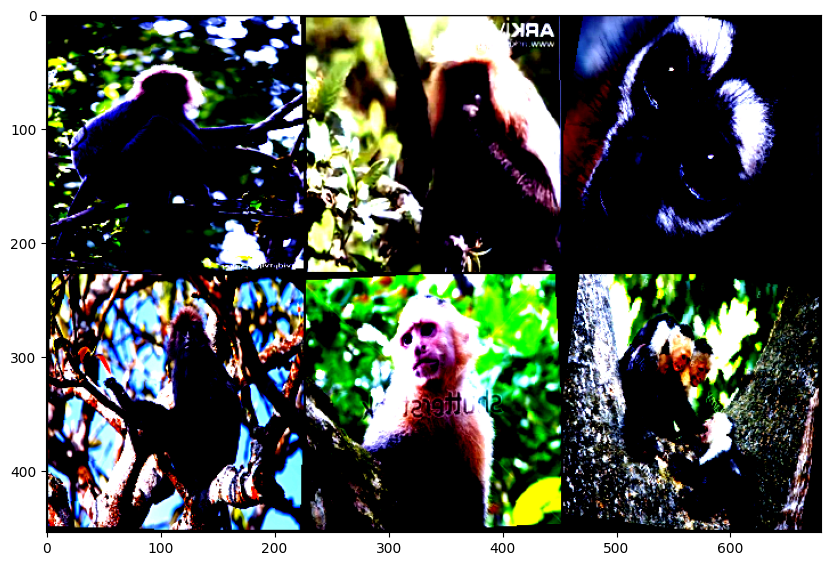

In [65]:
show_transformed_images (train_dataset)

In [66]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [67]:
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
    return torch.device(dev)

In [68]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
  device = set_device()
  best_acc = 0
  for epoch in range(n_epochs):
    print("Epoch number %d" % (epoch + 1))
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0

    for data in train_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      optimizer.zero_grad()

      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1)

      loss = criterion(outputs, labels)

      loss.backward()

      optimizer.step()

      running_loss += loss.item()

      running_correct += (labels==predicted).sum().item()
    epoch_loss = running_loss/len(train_loader)
    epoch_acc = 100.00 * running_correct/total

    print("  = Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f" % (running_correct, total, epoch_acc, epoch_loss))

    test_dataset_acc = evaluate_model_on_test_set(model, test_loader)

    if (test_dataset_acc > best_acc):
      best_acc = test_dataset_acc
      save_checkpoint(model, epoch, optimizer, best_acc)

  print("Finished!!")
  return model

In [69]:
def evaluate_model_on_test_set(model, test_loader):
  model.eval()
  predicted_correctly_on_epoch = 0
  total = 0
  device = set_device()

  with torch.no_grad():
    for data in test_loader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1)

      # Compare predicted labels directly to actual labels
      predicted_correctly_on_epoch += (predicted == labels).sum().item()
  epoch_acc = 100.00 * predicted_correctly_on_epoch/total
  print("  -Testing dataset.Got %d out of %d images correctly (%.3f%%)"
      % (predicted_correctly_on_epoch, total, epoch_acc))
  return epoch_acc

In [70]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained=False)
num_ftrs = resnet18_model.fc.in_features
number_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fun = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [54]:
# Train the model for 10 epochs
train_nn(resnet18_model, train_loader, test_loader, loss_fun, optimizer, 10)

Epoch number 1
  = Training dataset. Got 604 out of 658 images correctly (91.793%). Epoch loss: 0.229
  -Testing dataset. Got 133 out of 272 images correctly (48.897%)
Epoch number 2
  = Training dataset. Got 596 out of 658 images correctly (90.578%). Epoch loss: 0.261
  -Testing dataset. Got 123 out of 272 images correctly (45.221%)
Epoch number 3
  = Training dataset. Got 603 out of 658 images correctly (91.641%). Epoch loss: 0.246
  -Testing dataset. Got 125 out of 272 images correctly (45.956%)
Epoch number 4
  = Training dataset. Got 616 out of 658 images correctly (93.617%). Epoch loss: 0.218
  -Testing dataset. Got 131 out of 272 images correctly (48.162%)
Epoch number 5
  = Training dataset. Got 603 out of 658 images correctly (91.641%). Epoch loss: 0.266
  -Testing dataset. Got 102 out of 272 images correctly (37.500%)
Epoch number 6
  = Training dataset. Got 612 out of 658 images correctly (93.009%). Epoch loss: 0.226
  -Testing dataset. Got 129 out of 272 images correctly (4

In [73]:
# Data collected from the training process
epochs = list(range(1, 11))
train_accuracy = [91.793, 90.578, 91.641, 93.617, 91.641, 93.009, 93.313, 96.353, 97.416, 96.201]
test_accuracy = [48.897, 45.221, 45.956, 48.162, 37.500, 47.426, 52.941, 53.309, 46.324, 50.368]
train_loss = [0.229, 0.261, 0.246, 0.218, 0.266, 0.226, 0.199, 0.109, 0.098, 0.100]


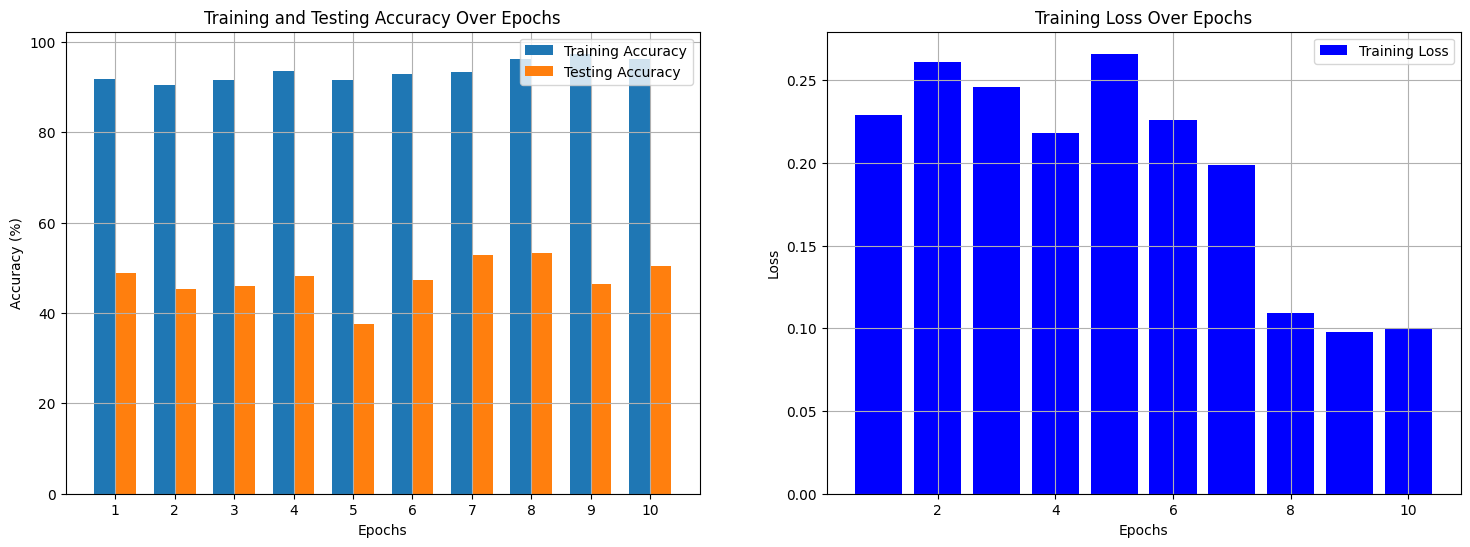

In [84]:
# Bar Graphs
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Bar Graph for Accuracy
bar_width = 0.35
index = np.arange(len(epochs))
axs[0].bar(index, train_accuracy, bar_width, label='Training Accuracy')
axs[0].bar(index + bar_width, test_accuracy, bar_width, label='Testing Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_title('Training and Testing Accuracy Over Epochs')
axs[0].set_xticks(index + bar_width / 2)
axs[0].set_xticklabels(epochs)
axs[0].legend()
axs[0].grid(True)

# Bar Graph for Training Loss
axs[1].bar(epochs, train_loss, color='blue', label='Training Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training Loss Over Epochs')
axs[1].legend()
axs[1].grid(True)

plt.show()

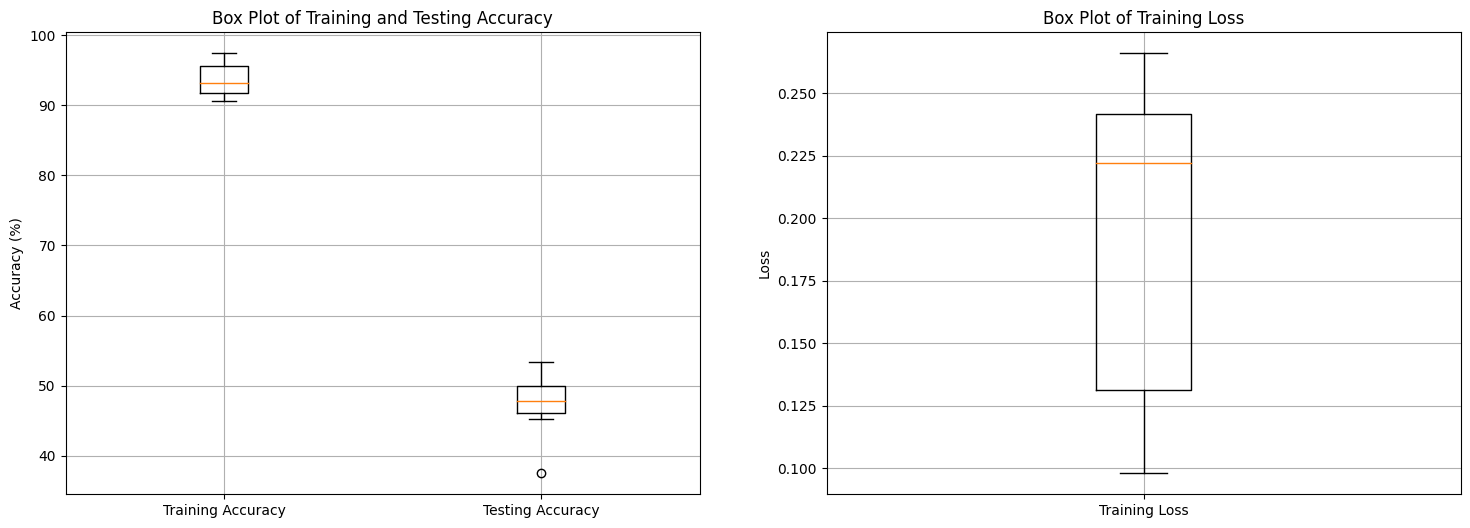

In [85]:
# Box Plots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Box Plot for Accuracy
axs[0].boxplot([train_accuracy, test_accuracy], labels=['Training Accuracy', 'Testing Accuracy'])
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_title('Box Plot of Training and Testing Accuracy')
axs[0].grid(True)

# Box Plot for Training Loss
axs[1].boxplot(train_loss, labels=['Training Loss'])
axs[1].set_ylabel('Loss')
axs[1].set_title('Box Plot of Training Loss')
axs[1].grid(True)

plt.show()

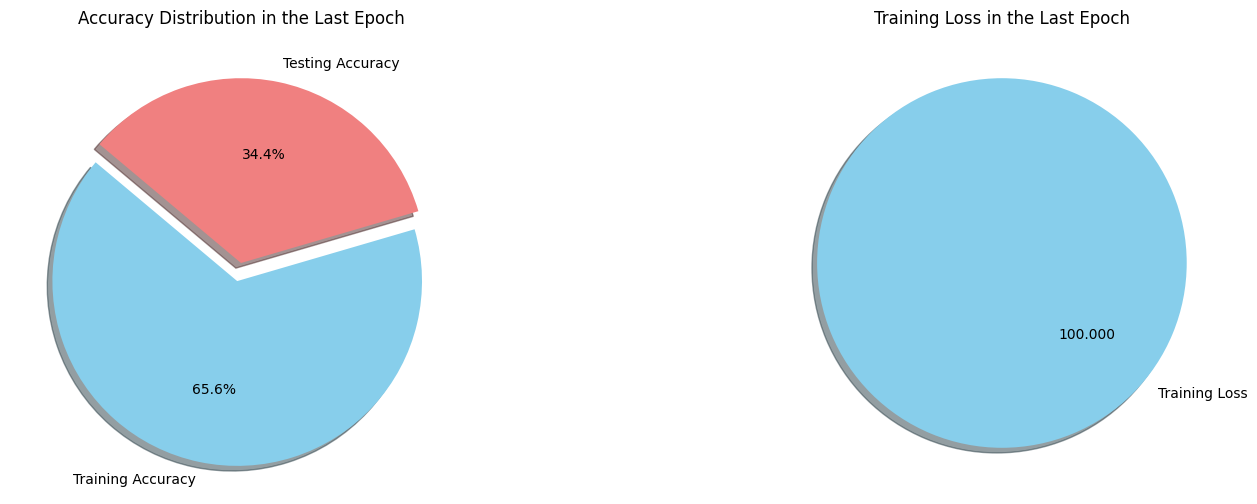

In [86]:
# Pie Charts
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Pie Chart for last epoch's accuracies
labels = ['Training Accuracy', 'Testing Accuracy']
sizes = [train_accuracy[-1], test_accuracy[-1]]
colors = ['skyblue', 'lightcoral']
explode = (0.1, 0)  # explode the 1st slice
axs[0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
axs[0].set_title('Accuracy Distribution in the Last Epoch')

# Pie Chart for last epoch's loss
labels = ['Training Loss']
sizes = [train_loss[-1]]
colors = ['skyblue']
axs[1].pie(sizes, labels=labels, colors=colors, autopct='%1.3f', shadow=True, startangle=140)
axs[1].set_title('Training Loss in the Last Epoch')

plt.show()


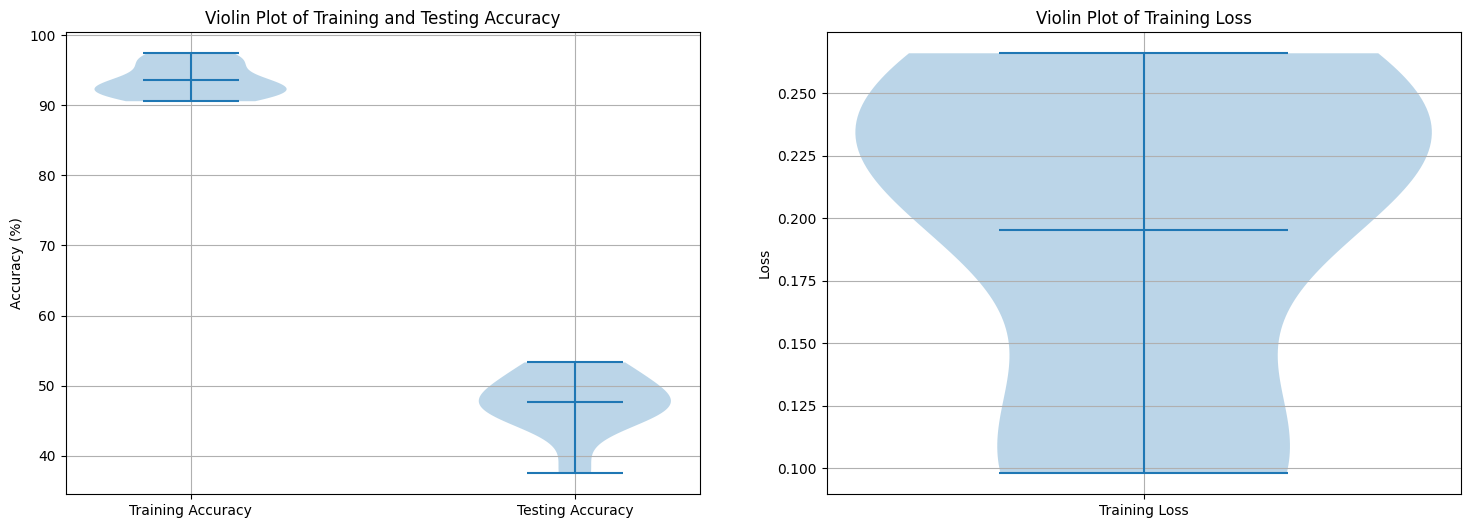

In [87]:
# Violin Plots
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Violin Plot for Accuracy
data = [train_accuracy, test_accuracy]
axs[0].violinplot(data, showmeans=True)
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['Training Accuracy', 'Testing Accuracy'])
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_title('Violin Plot of Training and Testing Accuracy')
axs[0].grid(True)

# Violin Plot for Training Loss
axs[1].violinplot(train_loss, showmeans=True)
axs[1].set_xticks([1])
axs[1].set_xticklabels(['Training Loss'])
axs[1].set_ylabel('Loss')
axs[1].set_title('Violin Plot of Training Loss')
axs[1].grid(True)

plt.show()